In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 64
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dermnet/train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dermnet/test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
)

Found 15557 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.


In [3]:
class_names = train_dataset.class_names
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

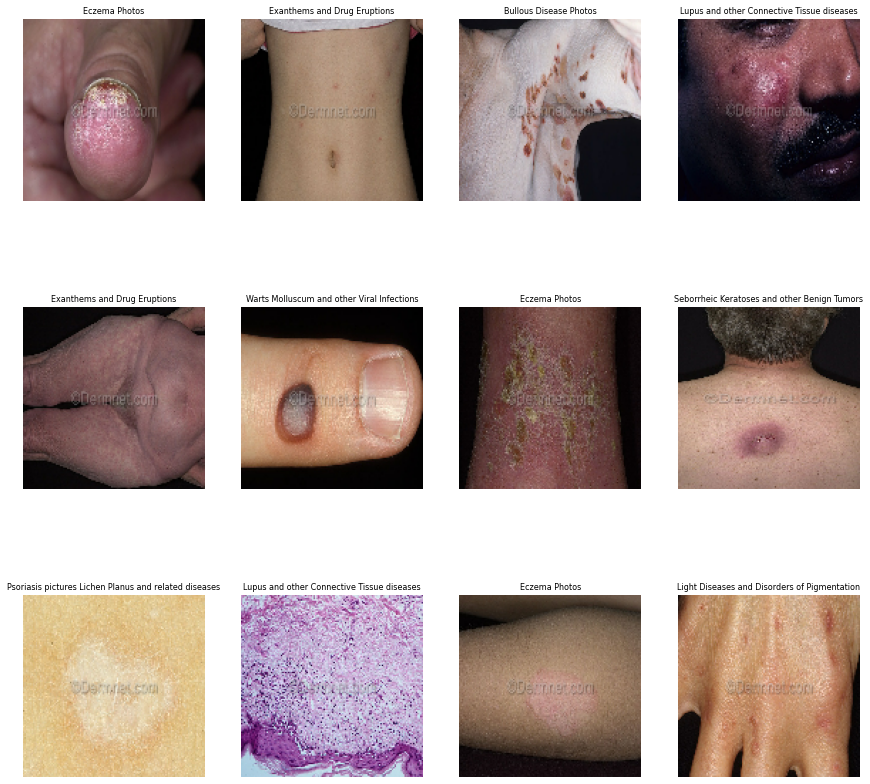

In [4]:
 plt.figure(figsize = (15,15))
 for image_batch, label_batch in train_dataset.take(1):
   for i in range(12):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]],fontsize = 8)
     plt.axis("off")
  #  print(image_batch.shape[0].shape)

In [5]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.2,shuffle = True,shuffle_size = 10000):
  assert(train_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds

In [6]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
model = models.Sequential([
                           resize_and_rescale,
                           layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3) ),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)), 
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)),    
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),    
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(23, activation='softmax')
])
model.build(input_shape = (BATCH_SIZE,128,128,3))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (64, 128, 128, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 126, 126, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (64, 63, 63, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 61, 61, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (64, 30, 30, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (64, 28, 28, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (64, 14, 14, 128)        

In [13]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
EPOCHS = 2
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
) 

Epoch 1/2
195/195 [==============================] - 328s 901ms/step - loss: 2.9777 - accuracy: 0.0912 - val_loss: 2.9200 - val_accuracy: 0.1081
Epoch 2/2
195/195 [==============================] - 171s 881ms/step - loss: 2.8949 - accuracy: 0.1389 - val_loss: 2.9161 - val_accuracy: 0.1302
